<a href="https://colab.research.google.com/github/Mancupfire/VinIndoorCare/blob/main/SPATIAL(Multi_Variable).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Masking
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import keras
import os
import itertools
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timedelta

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [4]:
# Define helper functions
def flattern(p):
    pred_y_matrix = [[] for _ in range(len(p[0]))]
    for pp in p:
        a = pp.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]
    return pred_y_matrix

In [5]:
# Interpolate the NaN values
def interpolate(data, mask):
    temp = [list(dd) for dd in data]
    d = []
    for i in range(len(temp)):
        for j in range(len(temp[i])):
            if temp[i][j] == mask:
                temp[i][j] = float("NaN")
        df = pd.Series(temp[i]).interpolate(method='linear')
        d.append(df.tolist())
    return d

In [6]:
def split_train(Int_dat, Norm_dat, T1, T2, T3, Stride, start, end, data_name):
    length = len(Int_dat[0])
    s = int(length * start)
    e = int(length * end)
    Train = [N[:s] + N[e:] for N in Norm_dat]
    Test = [M[s:e] for M in Int_dat]
    print('Training Data Length: ', len(Train), 'X', len(Train[0]))
    print('Test Data Length: ', len(Test), 'X', len(Test[0]))
    print('Testing percentage: ', len(Test[0])/(len(Test[0])+len(Train[0]))*100, '%')
    train_x, train_y = data_split(Train, T1, T2, T3, Stride)
    test_x, test_y = data_split(Test, T1, T2, T3, Stride)
    return train_x, train_y, test_x, test_y


In [7]:
def data_split(dat, train_hour, test_hour, predict_position, stride):
    x, y = [], []
    period = train_hour + predict_position + test_hour
    i = 0
    while i + period <= len(dat[0]):
        x_temp = []
        y_temp = []
        for j in range(len(dat)):
            x_temp.append(dat[j][i:i + train_hour])
            y_temp.append(dat[j][i + train_hour + predict_position:i + train_hour + predict_position + test_hour])
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    return np.array(x), np.array(y)


In [8]:
def data_normalize(Dat):
    new_dat = []
    for d in Dat:
        valid_vals = [val for val in d if val != -1]
        min_val = np.min(valid_vals) if valid_vals else 0
        max_val = np.max(valid_vals) if valid_vals else 1
        temp = []
        for val in d:
            if val == -1:
                temp.append(val)
            else:
                # Min-max scaling
                norm = (val - min_val) / (max_val - min_val) if max_val != min_val else 0
                temp.append(norm)
        new_dat.append(temp)
    return new_dat, [(min_val, max_val) for min_val, max_val in [(np.min([val for val in d if val != -1]), np.max([val for val in d if val != -1])) for d in Dat]]


In [9]:
# Load and align data for each sensor pair
def load_and_align_data(sensor_files, variables):
    data = []
    variable_names = []
    time_index = None

    for sensor_name, file_path in sensor_files.items():
        # Load data
        df = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')
        df.fillna(-1, inplace=True)

        # Align time index
        if time_index is None:
            time_index = df.index
        else:
            time_index = time_index.intersection(df.index)

    # After determining common time index, extract data
    for sensor_name, file_path in sensor_files.items():
        df = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')
        df.fillna(-1, inplace=True)

        # Extract each variable and add to the data list
        for var in variables:
            if var in df.columns:
                # Use the common time index for all data
                aligned_data = df.loc[time_index, var].tolist()
                data.append(aligned_data)
                variable_names.append(f"{sensor_name}_{var}")

    return data, variable_names, time_index


In [10]:
def stacked_LSTM(X, Y):
    import tensorflow as tf
    time_step = X.shape[1]
    input_dim = X.shape[2]
    out = Y.shape[2]
    model = Sequential()
    model.add(Masking(mask_value=-1., input_shape=(time_step, input_dim)))
    model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
    model.add(Dense(out))
    model.compile(
        loss='mean_absolute_error',
        optimizer=keras.optimizers.Adam(learning_rate=1e-5)
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Ép dùng GPU khi train
    with tf.device('/GPU:0'):
        hist = model.fit(
            X, Y,
            epochs=50,
            validation_split=0.2,
            verbose=1,
            batch_size=10,
            callbacks=[early_stopping]
        )

    model.summary()
    return model, hist

In [11]:
def SP_Learner(data, train_time, predict_time, predict_position, Stride, start, end, data_name):
    norm_dat, scaling_params = data_normalize(data)
    norm_int_dat = interpolate(norm_dat, -1)
    train_x, train_y, test_x, test_y = split_train(norm_int_dat, norm_dat, train_time, predict_time, predict_position, Stride, start, end, data_name)
    model, hist = stacked_LSTM(train_x, train_y)
    pred_y = model.predict(test_x, verbose=1)
    return pred_y, test_y, model, scaling_params


In [12]:
def evaluate_model(pred_y, test_y, variable_names, scaling_params, time_index, start):
    results = {}

    for i, var_name in enumerate(variable_names):
        # Get scaling parameters for this variable
        min_val, max_val = scaling_params[i]

        # Inverse transform to original units
        pred_original = pred_y[:,i,0] * (max_val - min_val) + min_val
        true_original = test_y[:,i,0] * (max_val - min_val) + min_val

        # Create time indices
        time_indices = pd.date_range(start=time_index[int(len(time_index) * start)],
                                   periods=len(pred_y[:,i,0]),
                                   freq=time_index[1] - time_index[0])

        # Find the best shift value
        shift_metrics = []
        for shift in range(-20, 1):
            shifted_pred = np.roll(pred_original, shift)
            if shift < 0:
                shifted_pred[shift:] = shifted_pred[shift-1]

            mae = mean_absolute_error(true_original, shifted_pred)
            rmse = np.sqrt(mean_squared_error(true_original, shifted_pred))
            r2 = r2_score(true_original, shifted_pred)
            mape = mean_absolute_percentage_error(true_original + 1e-10, shifted_pred + 1e-10) * 100  # Adding epsilon to avoid division by zero
            shift_metrics.append((shift, mae, rmse, r2, mape))

        shift_metrics.sort(key=lambda x: x[1])
        best_shift, best_mae, best_rmse, best_r2, best_mape = shift_metrics[0]

        best_pred = np.roll(pred_original, best_shift)
        if best_shift < 0:
            best_pred[best_shift:] = best_pred[best_shift-1]

        plt.figure(figsize=(15, 6))
        plt.plot(time_indices, best_pred, label=f'Predicted (Shift {best_shift})', alpha=0.7, color='blue')
        plt.plot(time_indices, true_original, label='True', alpha=0.7, color='red')

        plt.title(f'{var_name}: True vs Predicted Values with Best Shift (μg/m³)')
        plt.xlabel('Time')
        plt.ylabel('Concentration (μg/m³)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        results[var_name] = {
            'MAE': best_mae,
            'RMSE': best_rmse,
            'R²': best_r2,
            'MAPE': best_mape,
            'Best Shift': best_shift
        }

        print(f"\nBest metrics for {var_name}:")
        print(f"Best Shift: {best_shift} steps")
        print(f"MAE: {best_mae:.4f}")
        print(f"RMSE: {best_rmse:.4f}")
        print(f"R²: {best_r2:.4f}")
        print(f"MAPE: {best_mape:.4f}%")

    return results

In [15]:
# Configuration settings
train_time = 300       # Training sequence length
predict_time = 30      # Prediction sequence length
predict_position = 120 # Gap between training and prediction
stride = 15            # Stride for sequence generation
start = 0.8            # Training data proportion
end = 1.0              # Test data proportion
variables = ['PM2_5.ug.m3.']  # Target variable(s) to extract from each sensor

# Base path for sensor data files
base_path = '/content/1mins/'

all_sensors = {
    'sensor1': f'{base_path}01_01mins.csv',
    'sensor2': f'{base_path}02_01mins.csv',
    'sensor3': f'{base_path}03_01mins.csv',
    'sensor4': f'{base_path}04_01mins.csv'
}


Processing sensor pair: sensor1_sensor2
Loaded 2 variables from sensors: sensor1, sensor2
Variables: ['sensor1_PM2_5.ug.m3.', 'sensor2_PM2_5.ug.m3.']
Training Data Length:  2 X 103680
Test Data Length:  2 X 25920
Testing percentage:  20.0 %


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.1934 - val_loss: 0.0764
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1170 - val_loss: 0.0547
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0921 - val_loss: 0.0458
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0769 - val_loss: 0.0397
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0685 - val_loss: 0.0365
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0617 - val_loss: 0.0347
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0580 - val_loss: 0.0335
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0568 - val_loss: 0.0329
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0539 - val_loss: 0.0319
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0541 - val_loss: 0.0312
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0508 - val_loss: 0.0310
Epoch 12/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 2, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 2, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


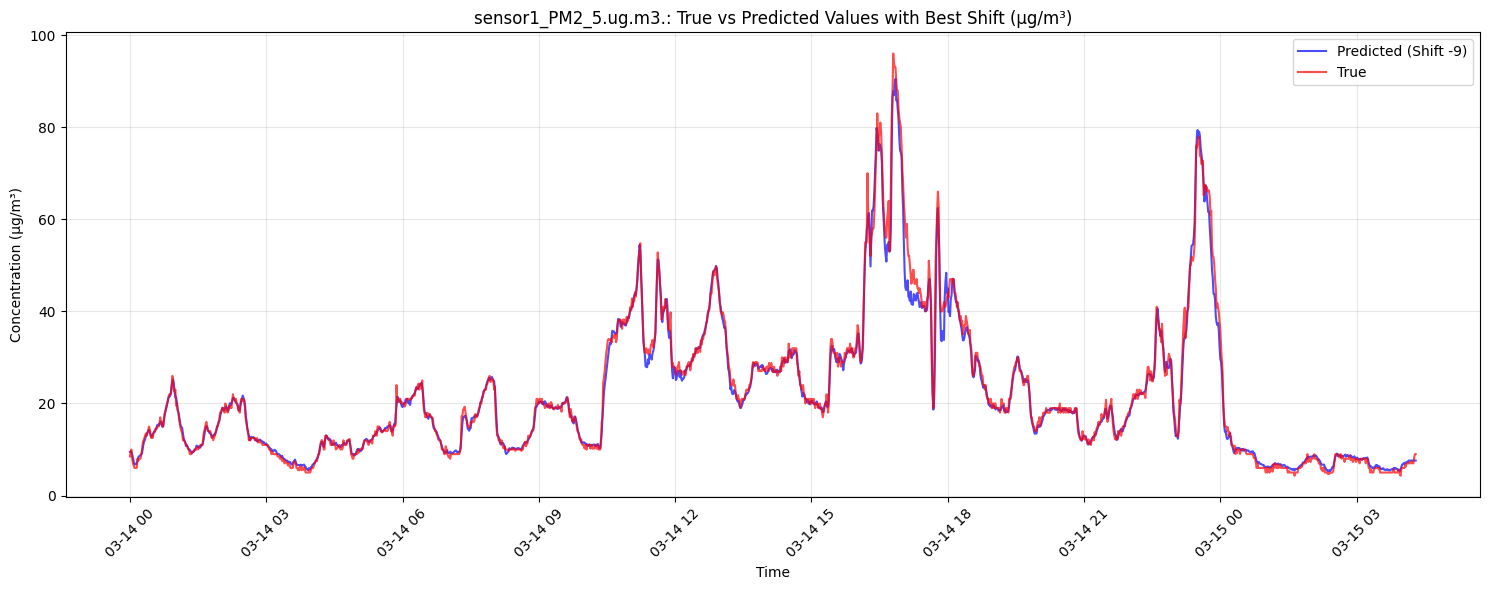


Best metrics for sensor1_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 0.9938
RMSE: 1.7403
R²: 0.9877
MAPE: 4.9691%


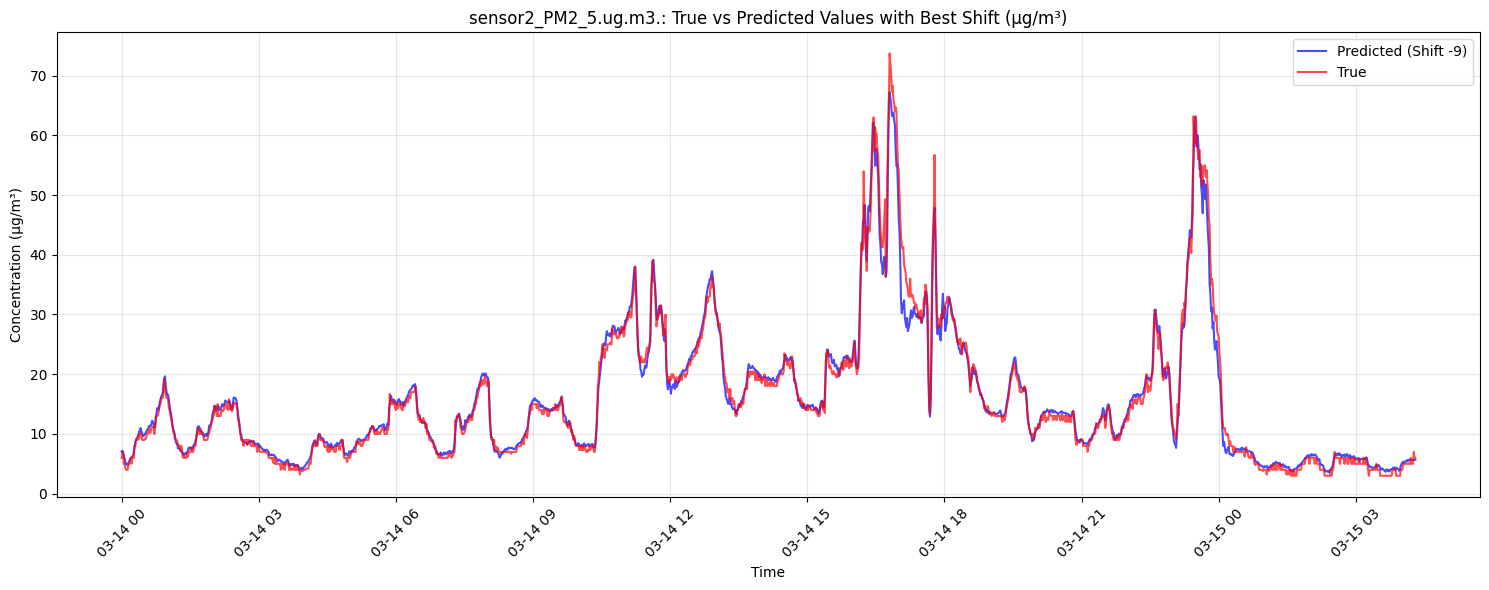


Best metrics for sensor2_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.0235
RMSE: 1.6347
R²: 0.9809
MAPE: 7.7368%

Processing sensor pair: sensor1_sensor3
Loaded 2 variables from sensors: sensor1, sensor3
Variables: ['sensor1_PM2_5.ug.m3.', 'sensor3_PM2_5.ug.m3.']
Training Data Length:  2 X 103680
Test Data Length:  2 X 25920
Testing percentage:  20.0 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1700 - val_loss: 0.0628
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0993 - val_loss: 0.0477
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0818 - val_loss: 0.0404
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0704 - val_loss: 0.0361
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0629 - val_loss: 0.0340
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0584 - val_loss: 0.0329
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0556 - val_loss: 0.0326
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0531 - val_loss: 0.0310
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0526 - val_loss: 0.0308
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0513 - val_loss: 0.0309
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0505 - val_loss: 0.0303
Epoch 12/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 2, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 2, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


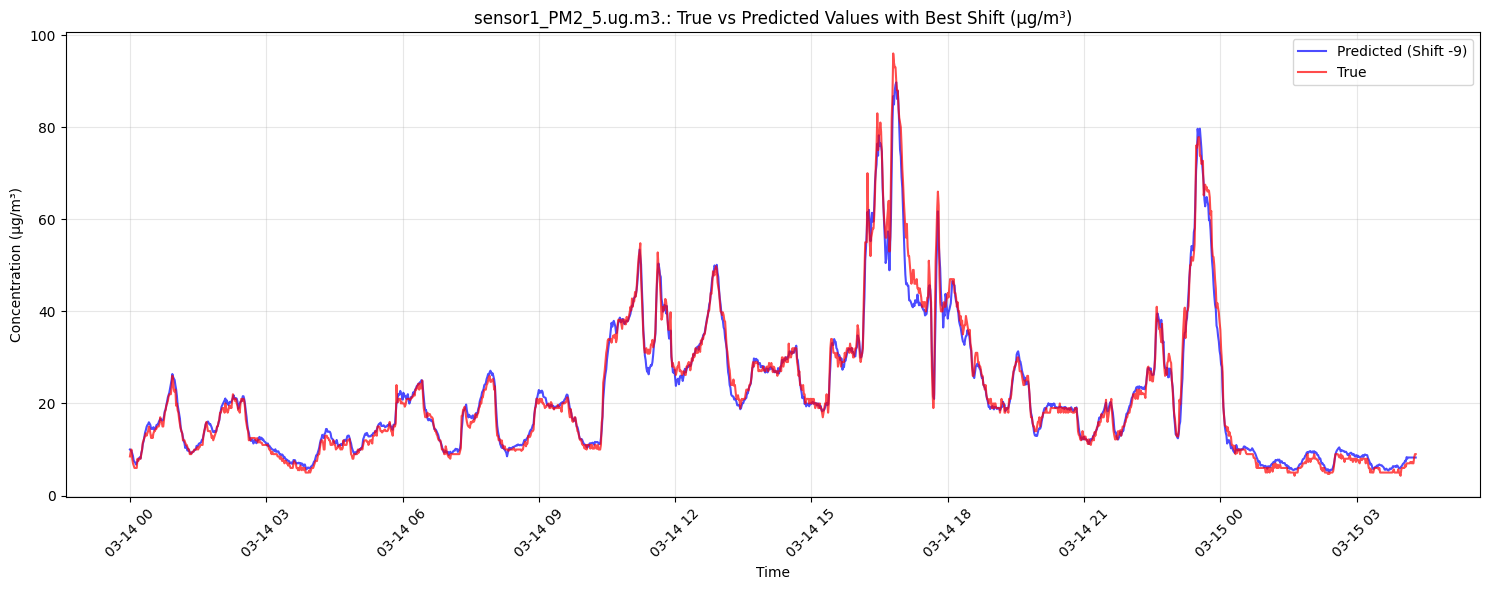


Best metrics for sensor1_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.3088
RMSE: 1.9502
R²: 0.9845
MAPE: 7.2693%


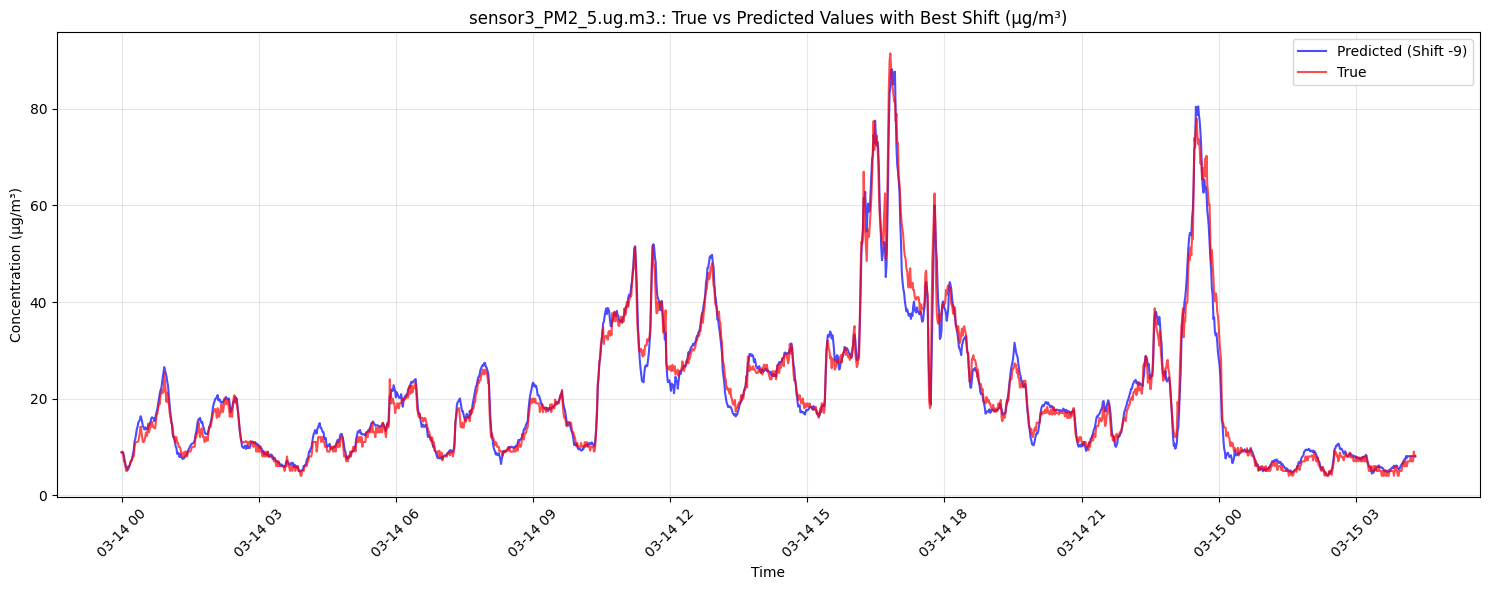


Best metrics for sensor3_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.5727
RMSE: 2.2854
R²: 0.9766
MAPE: 8.5985%

Processing sensor pair: sensor1_sensor4
Loaded 2 variables from sensors: sensor1, sensor4
Variables: ['sensor1_PM2_5.ug.m3.', 'sensor4_PM2_5.ug.m3.']
Training Data Length:  2 X 93891
Test Data Length:  2 X 23473
Testing percentage:  20.000170410006476 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.1583 - val_loss: 0.0612
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0878 - val_loss: 0.0453
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0712 - val_loss: 0.0393
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0625 - val_loss: 0.0359
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0554 - val_loss: 0.0338
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0533 - val_loss: 0.0323
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0519 - val_loss: 0.0319
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0478 - val_loss: 0.0313
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0488 - val_loss: 0.0304
Epoch 10/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0474 - val_loss: 0.0301
Epoch 11/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0462 - val_loss: 0.0299
Epoch 12/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)                  │ (None, 2, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 2, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


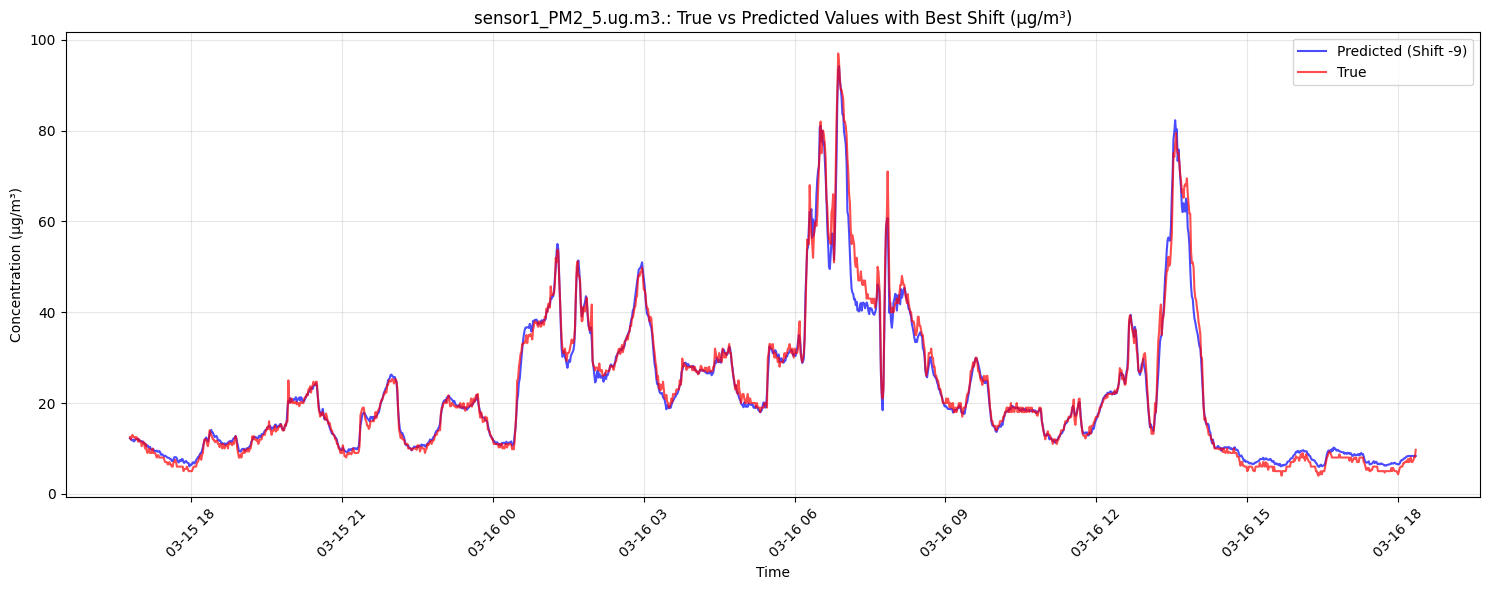


Best metrics for sensor1_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.2727
RMSE: 2.0432
R²: 0.9841
MAPE: 7.4621%


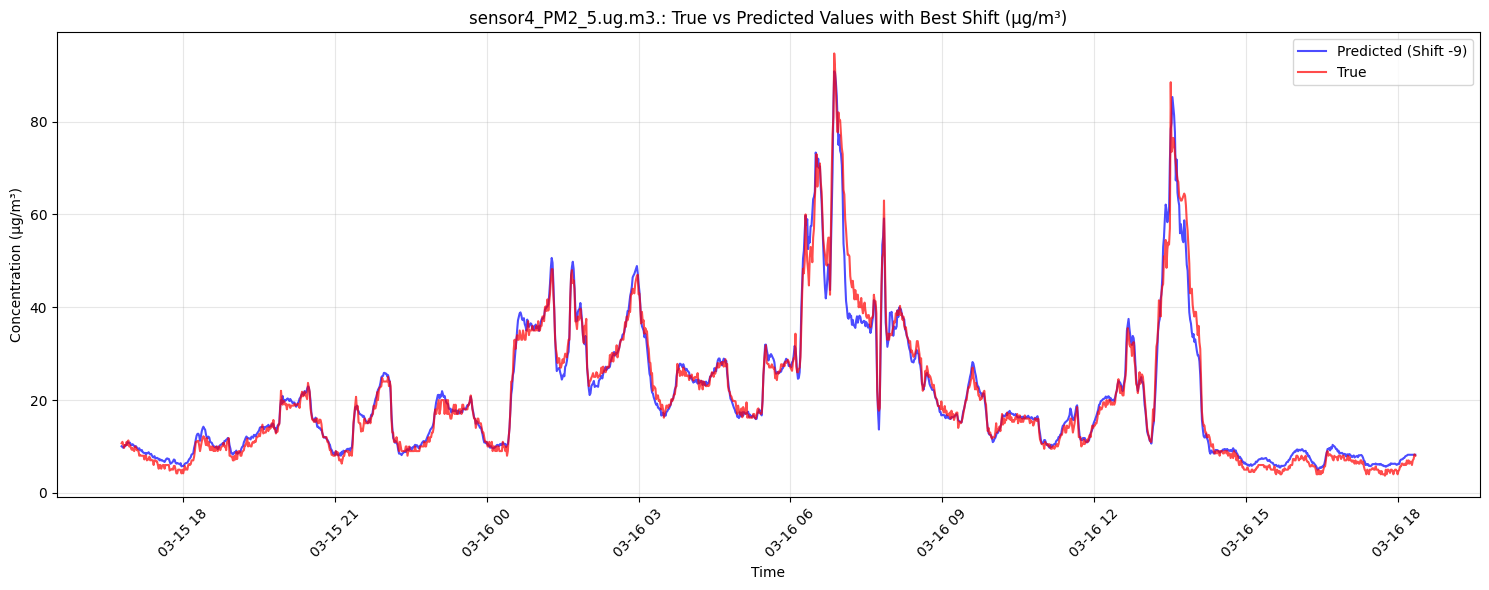


Best metrics for sensor4_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.5392
RMSE: 2.4011
R²: 0.9743
MAPE: 9.6424%

Processing sensor pair: sensor2_sensor3
Loaded 2 variables from sensors: sensor2, sensor3
Variables: ['sensor2_PM2_5.ug.m3.', 'sensor3_PM2_5.ug.m3.']
Training Data Length:  2 X 103680
Test Data Length:  2 X 25920
Testing percentage:  20.0 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1913 - val_loss: 0.0691
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1083 - val_loss: 0.0472
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0801 - val_loss: 0.0396
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0696 - val_loss: 0.0360
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0629 - val_loss: 0.0339
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0585 - val_loss: 0.0332
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0551 - val_loss: 0.0324
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0524 - val_loss: 0.0314
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0518 - val_loss: 0.0304
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0514 - val_loss: 0.0304
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0508 - val_loss: 0.0304
Epoch 12/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)                  │ (None, 2, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 2, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


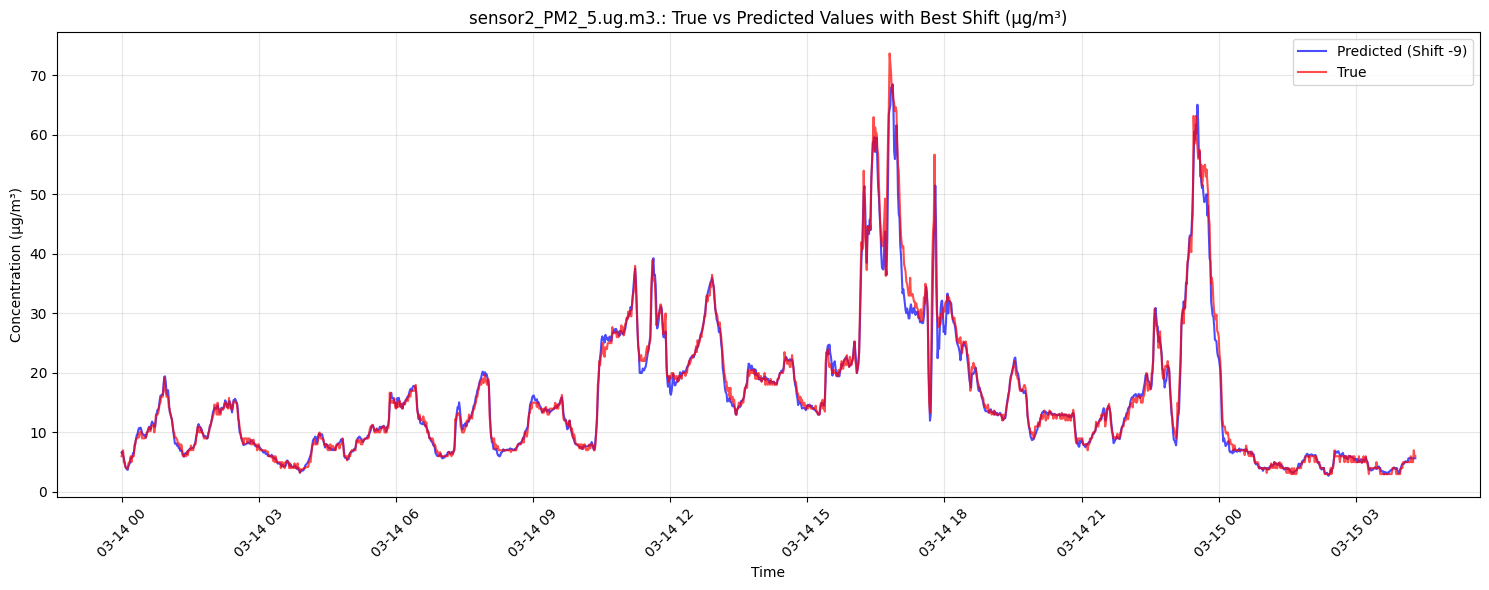


Best metrics for sensor2_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 0.8176
RMSE: 1.4486
R²: 0.9850
MAPE: 5.3642%


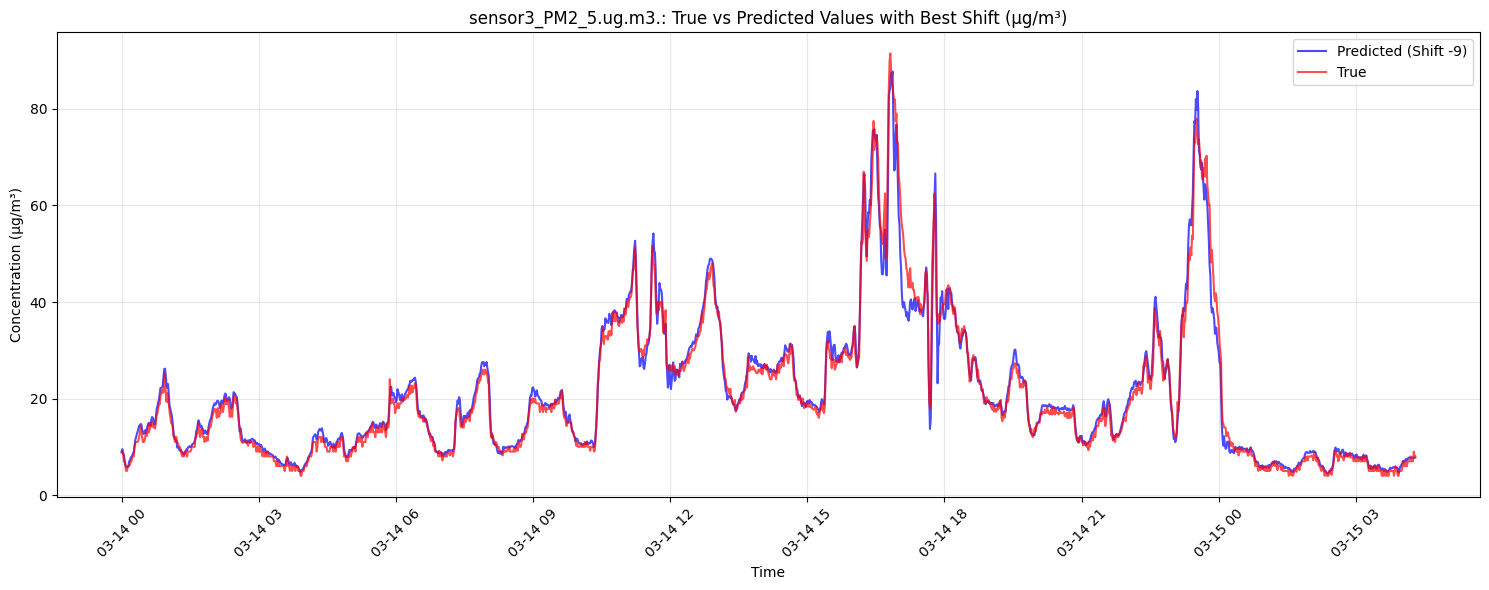


Best metrics for sensor3_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.4509
RMSE: 2.3126
R²: 0.9761
MAPE: 7.7215%

Processing sensor pair: sensor2_sensor4
Loaded 2 variables from sensors: sensor2, sensor4
Variables: ['sensor2_PM2_5.ug.m3.', 'sensor4_PM2_5.ug.m3.']
Training Data Length:  2 X 93891
Test Data Length:  2 X 23473
Testing percentage:  20.000170410006476 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.1365 - val_loss: 0.0590
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0868 - val_loss: 0.0462
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0703 - val_loss: 0.0400
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0615 - val_loss: 0.0362
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0558 - val_loss: 0.0339
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0522 - val_loss: 0.0324
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0489 - val_loss: 0.0319
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0486 - val_loss: 0.0312
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0479 - val_loss: 0.0306
Epoch 10/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0465 - val_loss: 0.0298
Epoch 11/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0452 - val_loss: 0.0294
Epoch 12/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)                  │ (None, 2, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 2, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


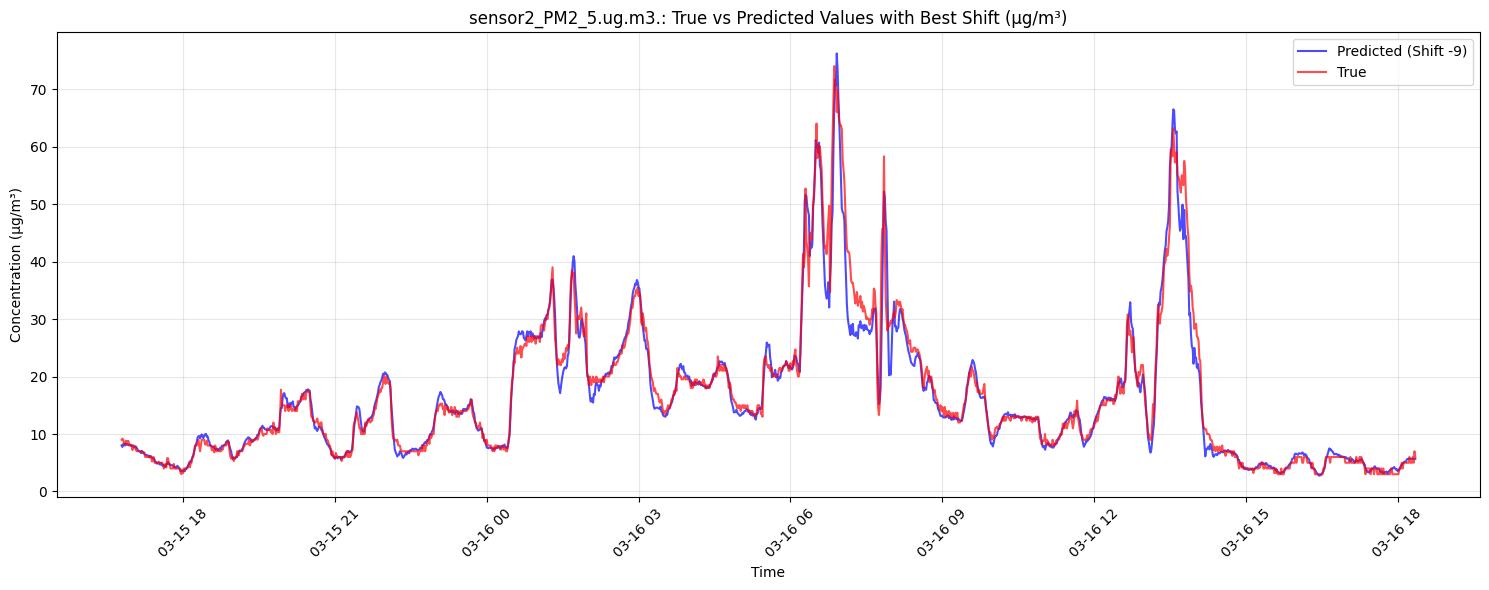


Best metrics for sensor2_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.3298
RMSE: 2.4195
R²: 0.9611
MAPE: 7.7840%


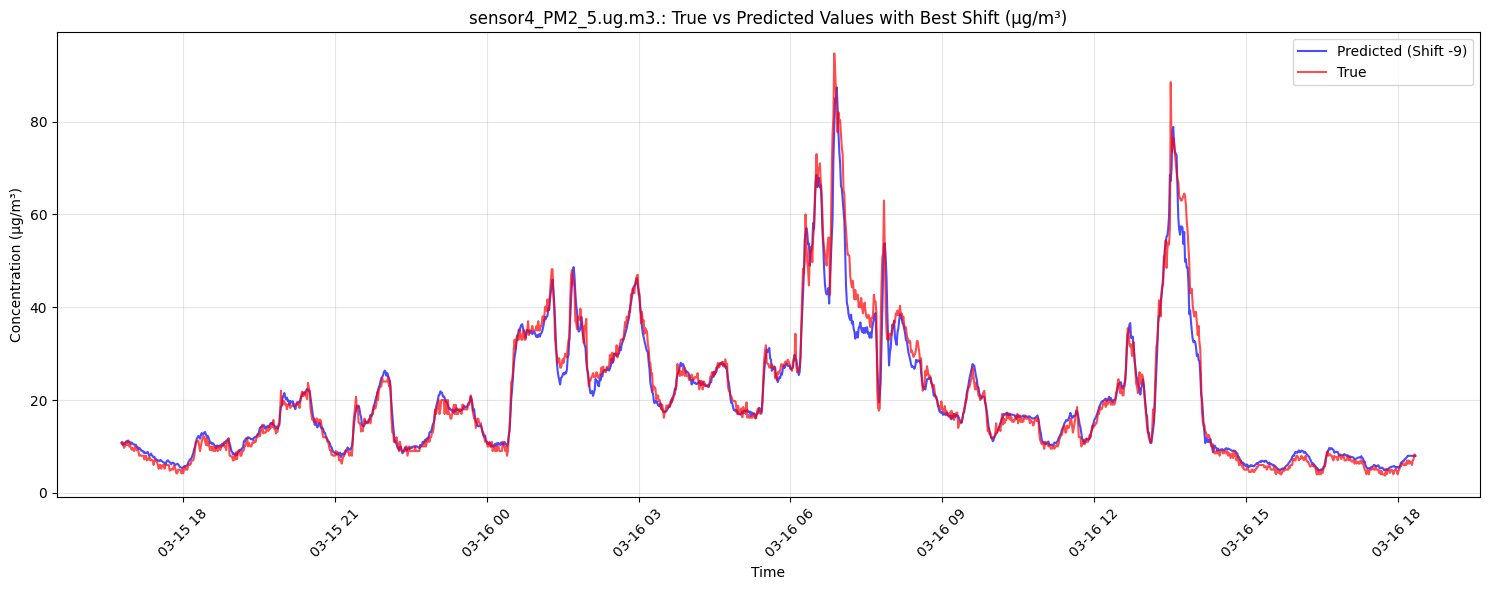


Best metrics for sensor4_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.6234
RMSE: 2.6625
R²: 0.9683
MAPE: 8.9086%

Processing sensor pair: sensor3_sensor4
Loaded 2 variables from sensors: sensor3, sensor4
Variables: ['sensor3_PM2_5.ug.m3.', 'sensor4_PM2_5.ug.m3.']
Training Data Length:  2 X 93891
Test Data Length:  2 X 23473
Testing percentage:  20.000170410006476 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.1319 - val_loss: 0.0552
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0849 - val_loss: 0.0448
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0719 - val_loss: 0.0387
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0616 - val_loss: 0.0349
Epoch 5/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0571 - val_loss: 0.0329
Epoch 6/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0515 - val_loss: 0.0318
Epoch 7/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0495 - val_loss: 0.0314
Epoch 8/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0481 - val_loss: 0.0304
Epoch 9/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0468 - val_loss: 0.0303
Epoch 10/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0472 - val_loss: 0.0295
Epoch 11/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0481 - val_loss: 0.0294
Epoch 12/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)                  │ (None, 2, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 2, 64)               │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2, 30)               │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,596 (1021.86 KB)

 Trainable params: 87,198 (340.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,398 (681.25 KB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


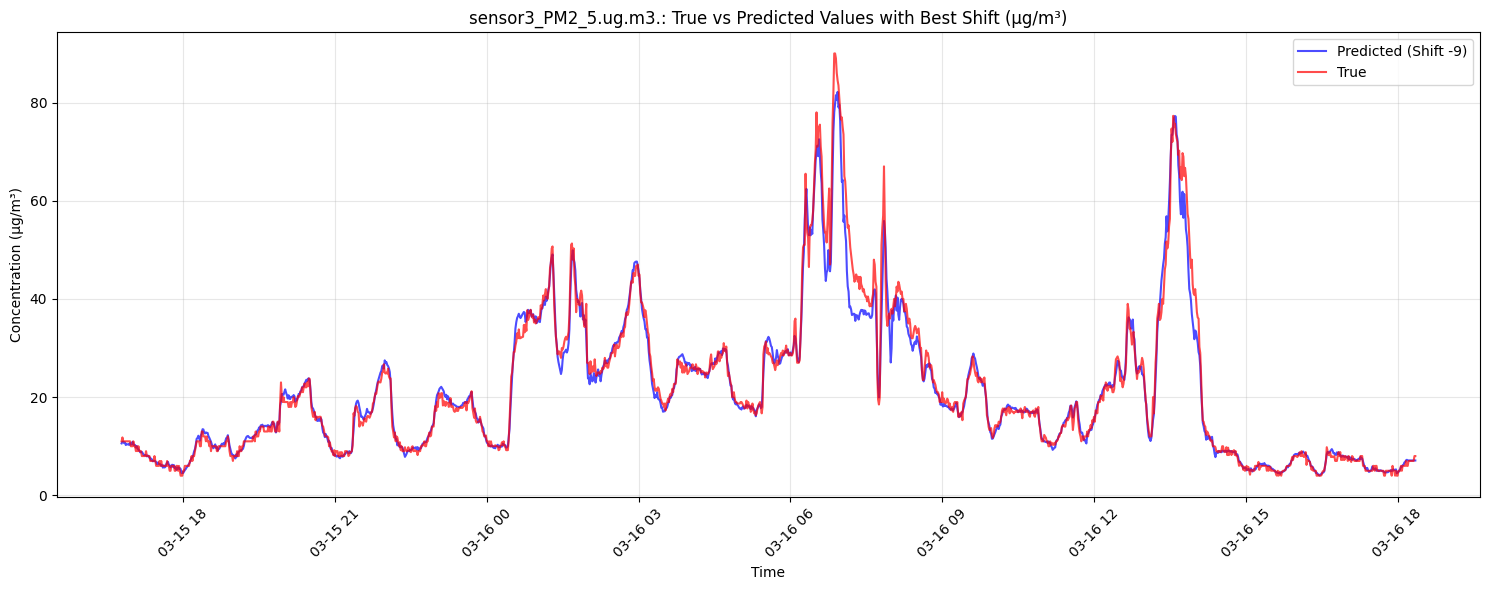


Best metrics for sensor3_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.4040
RMSE: 2.5293
R²: 0.9732
MAPE: 6.0438%


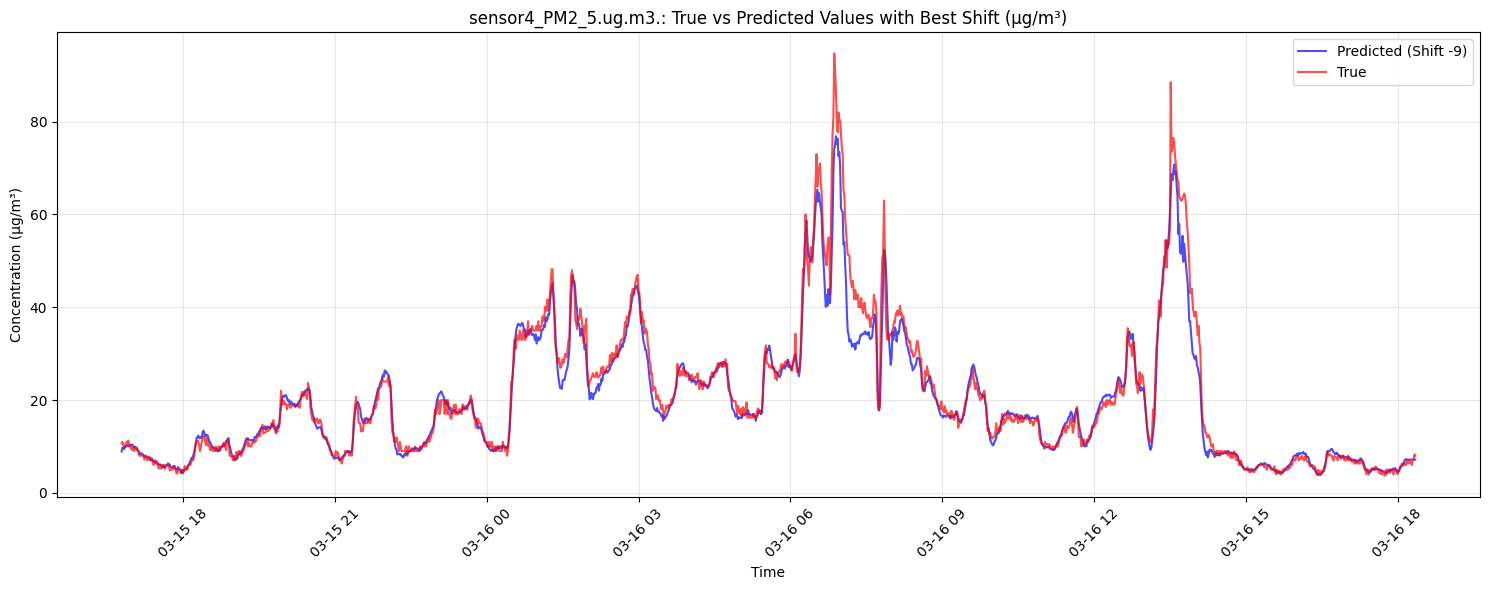


Best metrics for sensor4_PM2_5.ug.m3.:
Best Shift: -9 steps
MAE: 1.7539
RMSE: 3.1838
R²: 0.9547
MAPE: 7.7089%


In [16]:
# ## Dual Sensor Models
#
# Train and evaluate models for all possible pairs of sensors.

#
# Store results for all dual models
dual_sensor_results = {}

sensor_pairs = list(itertools.combinations(all_sensors.keys(), 2))

# Loop through each pair
for sensor_pair in sensor_pairs:
    sensor1, sensor2 = sensor_pair
    pair_name = f"{sensor1}_{sensor2}"

    print(f"\n{'='*50}")
    print(f"Processing sensor pair: {pair_name}")
    print(f"{'='*50}")

        # Create a dictionary with just these two sensors
    sensor_files = {
        sensor1: all_sensors[sensor1],
        sensor2: all_sensors[sensor2]
    }

    # Load aligned data
    data, variable_names, time_index = load_and_align_data(sensor_files, variables)

    if not data:
        print(f"No valid data found for {pair_name}. Skipping.")
        continue

    print(f"Loaded {len(data)} variables from sensors: {sensor1}, {sensor2}")
    print("Variables:", variable_names)

    # Train model and get predictions
    pred_y, test_y, model, scaling_params = SP_Learner(
        data,
        train_time,
        predict_time,
        predict_position,
        stride,
        start,
        end,
        f'AirQuality_{pair_name}'
    )

    # Evaluate model
    results = evaluate_model(pred_y, test_y, variable_names, scaling_params, time_index, start)

    # Store results
    dual_sensor_results[pair_name] = results

In [21]:
# ## Results Summary
#
# Compile all results into comprehensive tables for comparison.

# Create a consolidated results table for dual sensor models
dual_results_table = []
for pair_name, results in dual_sensor_results.items():
    for var_name, metrics in results.items():
        dual_results_table.append({
            'Sensor Pair': pair_name,
            'Variable': var_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R²': metrics['R²'],
            'MAPE (%)': metrics['MAPE'],
            'Best Shift': metrics['Best Shift']
        })

dual_df = pd.DataFrame(dual_results_table)
print("\nDual Sensor Model Results:")
display(dual_df)



Dual Sensor Model Results:


,Sensor Pair,Variable,MAE,RMSE,R²,MAPE (%),Best Shift
0,sensor1_sensor2,sensor1_PM2_5.ug.m3.,0.993841,1.740276,0.987656,4.969129,-9
1,sensor1_sensor2,sensor2_PM2_5.ug.m3.,1.023463,1.634663,0.980854,7.736792,-9
2,sensor1_sensor3,sensor1_PM2_5.ug.m3.,1.308807,1.950214,0.984498,7.269299,-9
3,sensor1_sensor3,sensor3_PM2_5.ug.m3.,1.572695,2.285364,0.976634,8.598479,-9
4,sensor1_sensor4,sensor1_PM2_5.ug.m3.,1.272742,2.043170,0.984071,7.462134,-9
5,sensor1_sensor4,sensor4_PM2_5.ug.m3.,1.539204,2.401057,0.974250,9.642364,-9
6,sensor2_sensor3,sensor2_PM2_5.ug.m3.,0.817645,1.448597,0.984965,5.364191,-9
7,sensor2_sensor3,sensor3_PM2_5.ug.m3.,1.450946,2.312570,0.976075,7.721463,-9
8,sensor2_sensor4,sensor2_PM2_5.ug.m3.,1.329784,2.419466,0.961087,7.784009,-9
9,sensor2_sensor4,sensor4_PM2_5.ug.m3.,1.623441,2.662514,0.968337,8.908627,-9


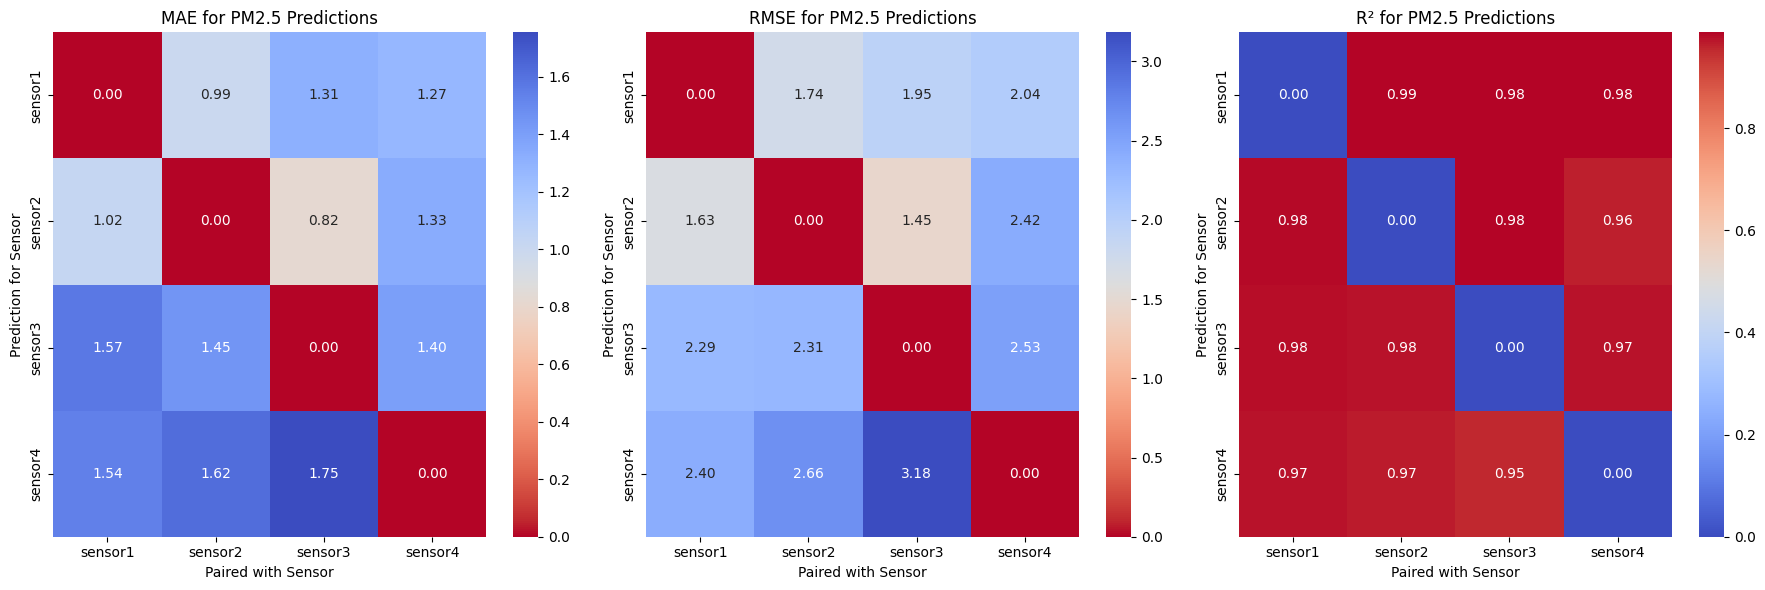

In [22]:
# Create a heatmap visualization for dual-sensor performance comparison
# Extract just the PM2.5 results
pm25_results = {}

# All sensor names
sensor_names = list(all_sensors.keys())

# Initialize metric matrices
mae_matrix = np.zeros((len(sensor_names), len(sensor_names)))
rmse_matrix = np.zeros((len(sensor_names), len(sensor_names)))
r2_matrix = np.zeros((len(sensor_names), len(sensor_names)))

# Fill in dual sensor results
for pair_name, results in dual_sensor_results.items():
    sensor1, sensor2 = pair_name.split('_')
    i = sensor_names.index(sensor1)
    j = sensor_names.index(sensor2)

    # Find the PM2.5 result for sensor1
    for var_name, metrics in results.items():
        if 'PM2_5.ug.m3.' in var_name and sensor1 in var_name:
            mae_matrix[i, j] = metrics['MAE']
            rmse_matrix[i, j] = metrics['RMSE']
            r2_matrix[i, j] = metrics['R²']

        # Find the PM2.5 result for sensor2
        if 'PM2_5.ug.m3.' in var_name and sensor2 in var_name:
            mae_matrix[j, i] = metrics['MAE']
            rmse_matrix[j, i] = metrics['RMSE']
            r2_matrix[j, i] = metrics['R²']

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MAE Heatmap
sns.heatmap(mae_matrix, annot=True, fmt='.2f', cmap='coolwarm_r',
            xticklabels=sensor_names, yticklabels=sensor_names, ax=axes[0])
axes[0].set_title('MAE for PM2.5 Predictions')
axes[0].set_xlabel('Paired with Sensor')
axes[0].set_ylabel('Prediction for Sensor')

# RMSE Heatmap
sns.heatmap(rmse_matrix, annot=True, fmt='.2f', cmap='coolwarm_r',
            xticklabels=sensor_names, yticklabels=sensor_names, ax=axes[1])
axes[1].set_title('RMSE for PM2.5 Predictions')
axes[1].set_xlabel('Paired with Sensor')
axes[1].set_ylabel('Prediction for Sensor')

# R² Heatmap
sns.heatmap(r2_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=sensor_names, yticklabels=sensor_names, ax=axes[2])
axes[2].set_title('R² for PM2.5 Predictions')
axes[2].set_xlabel('Paired with Sensor')
axes[2].set_ylabel('Prediction for Sensor')

plt.tight_layout()
plt.show()